In [1]:
from IPython import display
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pretty_midi
import seaborn as sns
import tensorflow as tf

from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

# Tomb added
import random

In [2]:
#Download Chorales
data_dir = pathlib.Path('/Volumes/MAGIC1/CS50/myMusicGen/data/chorales')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'midi',
      origin='https://github.com/jamesrobertlloyd/infinite-bach/tree/master/data/chorales/midi',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(filenames)
print('Number of files:', len(filenames))

['/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000101b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000106b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000106trio.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000206b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000306b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000408b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000504b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000507b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000603b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000606b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000707b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000806b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/000907b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/001007b_.mid', '/Volumes/MAGIC1/CS50/myMusicGen/data/chorales/midi/001106b

In [3]:
class UnsupportedMidiFileException(Exception):
  "Unsupported MIDI File"

In [4]:
seqlen = 64
vocab_size = 128

In [5]:
def get_pianoroll(midi, nn_from, nn_thru, seqlen, tempo):
    pianoroll = midi.get_piano_roll(fs=2*tempo/60) # This is the core line which makes this matrix based on 8th note

    # print(f"piano_roll.shape[1] a.k.a song length!{pianoroll.shape[1]}")

    if pianoroll.shape[1] < seqlen:
        raise UnsupportedMidiFileException

    pianoroll = pianoroll[nn_from:nn_thru, 0:seqlen] # Pinoroll's value still NOT binary since it has velocity
    binary_pianoroll = np.heaviside(pianoroll, 0) # converting as a binary matrix
    transposed_pianoroll = np.transpose(binary_pianoroll)


    def check_pianoroll_dim(pianoroll):
        rows = len(pianoroll)  # This gives the number of rows
        columns = len(pianoroll[0])  # This assumes all rows have the same length

        print("Number of rows:", rows) # represents sequence length
        print("Number of columns:", columns) # represents the 4 octave range in midi 36-83
        print("Total dimesions of pianoroll is", rows*columns)
    
    # check_pianoroll_dim(transposed_pianoroll)
    
    # return binary_pianoroll
    return transposed_pianoroll

#### Read_Midi Explanation

Get Major key(keymode=0) or Minor key(keymode=1)<br>
key_number has values ​​from 0 to 11 for major keys and for minor keys,
12~23 is included, <br> so by **dividing it by 12** and converting it to an integer,<br> 

it will be 0 if it is a major key,<br>
it will be 1 if it is a minor key,<br>

and assign it accordingly to keymode.

In [6]:
def read_midi(filename, sop_alto, seqlen):
  
  def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
    rests = 1 - np.sum(pianoroll, axis=1)
    rests = np.expand_dims(rests, 1)
    return np.concatenate([pianoroll, rests], axis=1)
  
  
  # read midi file
  midi = pretty_midi.PrettyMIDI(filename)

  # An Exception error is thrown if there is a modulation(key change)
  if len(midi.key_signature_changes) !=1:
    raise UnsupportedMidiFileException

  # Modulate the given key to C major or C minor
  key_number = midi.key_signature_changes[0].key_number
  # transpose_to_c(midi, key_number)

  # Get Major key(keynode=0) or Minor key(keynode=1)
  keymode = np.array([int(key_number / 12)])

  # The Exception error thrown when tempo changes
  tempo_time, tempo = midi.get_tempo_changes()
  if len(tempo) != 1:
    raise UnsupportedMidiFileException
  if sop_alto:
    # The exception thrown if there are less than 2 parts
    if len(midi.instruments) < 2:
      raise UnsupportedMidiFileException
    # Get pianoRoll binary Matrix for each of Soprano and alto parts
    pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0])
    pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
    pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])
    
    sop_w_rest = add_rest_nodes(pr_s)
    alt_w_rest = add_rest_nodes(pr_a)
    bass_w_rest = add_rest_nodes(pr_b)
    
    # return pr_s, pr_a, pr_b, keymode
    return sop_w_rest, alt_w_rest, bass_w_rest, keymode

  else:
    # Get a pianoroll which gathered all the parts
    pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
    return pr, keymode

#### Make the training data

In [7]:
"""Get the ingredients"""
np.set_printoptions(threshold=np.inf) # Show the entire print, esp Matrix

x_all = [] # shape will be (495, 64, 49) the list which stores inputs of soprano melodies
y_all = [] # shape will be (495, 64, 49) the list which stores outputs of alto melodies
keymodes = [] # the list which stores the key whether it is major or minor
files = [] # stores the filenames of the MIDI files

# repeat the process with all the midi files
for f in glob.glob(str(data_dir/"**/*.mid*")):
  # print(f)
  try:
    sop, alt, bass, keymode = read_midi(f, True, 64)

    # add pianorolls which have been added rest elements to the lists
    x_all.append(sop)
    y_all.append(alt)
    keymodes.append(keymode)
    files.append(f)
  # throw exception for midi data which can not be used
  except UnsupportedMidiFileException:
    print("nah")

n_notes = len(x_all) # Not sure if it is correct
print(n_notes)

# convert x_all and y_all into NumPy array to make them more useful later

# Tomb added. These three lines of code is for getting the number of pitch range
# The pitch range is 49 at this point as rest_node dim is added, refer to prof's docu
x_all = np.array(x_all)
y_all = np.array(y_all)

print(x_all.shape[2])
pitch_range = x_all.shape[2]

# x_all = np.array(x_all)
# y_all = np.array(y_all)

# You get an error with this  code but can see the shape
# x = pd.DataFrame(y_all)
# print(x)

nah
nah
nah
495
49


### Attempt getting data 

In [8]:
# the range method returns a sequencce of numbers(0, 495), so it satisfies the test_split parameters
i_train, i_test = train_test_split(range(len(x_all)),
                                   test_size=int(len(x_all)/2), shuffle=False)
print(range(len(x_all)))

x_train = x_all[i_train]
x_test = x_all[i_test]

y_train = y_all[i_train]
y_test = y_all[i_test]

range(0, 495)


In [9]:
seq_length = x_train.shape[1] #64
input_dim = x_train.shape[2] #49
output_dim = y_train.shape[2] #49

model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(
    128, input_shape=(seq_length, input_dim), use_bias=True,
    activation="tanh", return_sequences=True
))
model.add(tf.keras.layers.Dense(
    output_dim, use_bias=True, activation="softmax"
))
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics="categorical_accuracy")

model.evaluate(x_test, y_test)

model.summary()


8/8 [==============================] - 0s 4ms/step - loss: 3.9616 - categorical_accuracy: 0.0180
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64, 128)           22784     
                                                                 
 dense (Dense)               (None, 64, 49)            6321      
                                                                 
Total params: 29105 (113.69 KB)
Trainable params: 29105 (113.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )]

epochs = 50
batch_size = 32

history = model.fit(
    x_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks)

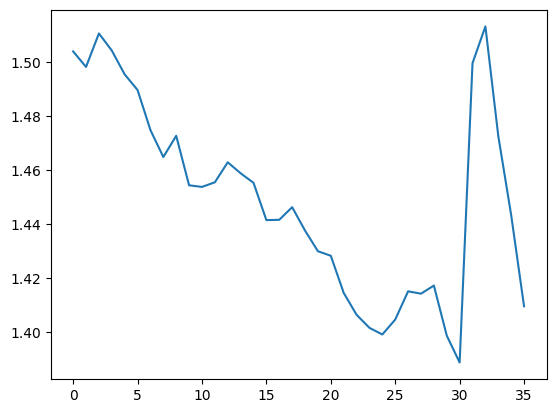

In [29]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Generate Notes

In [ ]:
# y_pred = model.predict(x_test) # returns numpy.ndarray

In [55]:
def predict_next_note(
        notes: np.ndarray,
        model: tf.keras.Model,
        temperature: float = 1.0) -> tuple[int]: # -> indicates what you return
    """Generates a note, using a trained sequence model."""
    assert temperature > 0 
    # Add batch dimension
    # inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(notes) # predictions (64, 64, 49)  
    note_logits = predictions[1] # make a 2D tensor for random.categoriacal's 1st arg. note_logits (64, 49)
    note_logits /= temperature
    print("note_logits", note_logits.shape)
    pitch = tf.random.categorical(note_logits, num_samples=1) #random.categorical requires 2D tensor for logits
    pitch = tf.squeeze(pitch, axis=-1)
    # print(f"pitch after squeezed{pitch}")
    
    print("pitch",pitch)
    return pitch

In [64]:
temperature = 2.0
num_predictions = 10

input_notes = y_test[: seq_length]



generated_notes = predict_next_note(input_notes, model, temperature)

generated_notes = pd.DataFrame(
    generated_notes
)
generated_notes.head(10)

2/2 [==============================] - 0s 5ms/step
note_logits (64, 49)
pitch tf.Tensor(
[ 5 26 24 10  4 27 45 47 21  2 23 23 36 35 12 42 26 33  8 41 37  2 15  9
 41 29 26 37  3 44 42 28 26  3 24  5 12 42  3 45 14 34  9 41 37 19 26  8
 33 41 46 47  6 29 23  7 40 27 18 41 20 20 44 48], shape=(64,), dtype=int64)


,0
0,5
1,26
2,24
3,10
4,4
5,27
6,45
7,47
8,21
9,2


In [101]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:
  
  print("notes pd.Data", notes)

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  
  for i, note in notes.iterrows():
    print("note!!", note)
    start = float(prev_start + note)
    end = float(start + note)
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [102]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=40):
    waveform = pm.fluidsynth(fs=float(_SAMPLING_RATE))
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [103]:
out_file = "output.mid"
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name="Acoustic Grand Piano"
)
display_audio(out_pm)

notes pd.Data      0
0    5
1   26
2   24
3   10
4    4
..  ..
59  41
60  20
61  20
62  44
63  48

[64 rows x 1 columns]
note!! 0    5
Name: 0, dtype: int64
note!! 0    26
Name: 1, dtype: int64
note!! 0    24
Name: 2, dtype: int64
note!! 0    10
Name: 3, dtype: int64
note!! 0    4
Name: 4, dtype: int64
note!! 0    27
Name: 5, dtype: int64
note!! 0    45
Name: 6, dtype: int64
note!! 0    47
Name: 7, dtype: int64
note!! 0    21
Name: 8, dtype: int64
note!! 0    2
Name: 9, dtype: int64
note!! 0    23
Name: 10, dtype: int64
note!! 0    23
Name: 11, dtype: int64
note!! 0    36
Name: 12, dtype: int64
note!! 0    35
Name: 13, dtype: int64
note!! 0    12
Name: 14, dtype: int64
note!! 0    42
Name: 15, dtype: int64
note!! 0    26
Name: 16, dtype: int64
note!! 0    33
Name: 17, dtype: int64
note!! 0    8
Name: 18, dtype: int64
note!! 0    41
Name: 19, dtype: int64
note!! 0    37
Name: 20, dtype: int64
note!! 0    2
Name: 21, dtype: int64
note!! 0    15
Name: 22, dtype: int64
note!! 0    9
Name: 

/var/folders/18/bjw473gs5kzglmdg42c9kl880000gn/T/ipykernel_12745/1144214354.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  start = float(prev_start + note)
/var/folders/18/bjw473gs5kzglmdg42c9kl880000gn/T/ipykernel_12745/1144214354.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  end = float(start + note)
/var/folders/18/bjw473gs5kzglmdg42c9kl880000gn/T/ipykernel_12745/1144214354.py:23: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  pitch=int(note),


### --Experimental or Unused code Below-- 

In [11]:
"""Attempted by using tf.data.Dataset for trainig data"""
# x_ds = tf.data.Dataset.from_tensor_slices(x_all)
# y_ds = tf.data.Dataset.from_tensor_slices(y_all)
# print(x_ds.element_spec)
# for i, f in enumerate(x_ds):
#     print(i, f.numpy())

# note_ds = tf.data.Dataset.from_tensor_slices(x_all)
# note_ds.element_spec

'Attempted by using tf.data.Dataset for trainig data'

In [12]:
# seq_ds = create_sequences(note_ds, seqlen, vocab_size) # Vocab size is not used yet as I do not know how to handle normlization with this data

# print(seq_ds.element_spec)


In [13]:
# elm = 2
# for seq in x_seq_ds.take(1):

#   print('sequence shape:', seq.shape)
#   print(f'sequence elements (first {elm}):', seq[0: elm]) 

In [14]:
# batch_size = 64
# buffer_size = n_notes - seqlen

# train_ds = (seq_ds
#             .shuffle(buffer_size)
#             # .batch(batch_size, drop_remainder=True)
#             .cache()
#             .prefetch(tf.data.experimental.AUTOTUNE)
#             )

# print(train_ds.element_spec) # (batch_size, seqlen, pitch_range)

In [15]:
# input_shape = (seqlen, pitch_range) # (64, 49)
# learning_rate = 0.005

# inputs = tf.keras.Input(input_shape)
# x = tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True)(inputs)
# outputs = tf.keras.layers.Dense(1)(x)

# model = tf.keras.Model(inputs, outputs)

# loss = tf.keras.losses.CategoricalCrossentropy(
#         from_logits=True) # To set True automatically adds softmax

# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# metrics = tf.keras.metrics.CategoricalCrossentropy()

# model.compile(loss=loss,
#               optimizer=optimizer,
#               metrics=[metrics])
# model.summary()


In [16]:
# losses = model.evaluate(train_ds, return_dict=True)
# losses

In [17]:
"""Check the dimension of the matrix"""

# rows = len(training_data)
# columns = len(training_data[0]) if training_data else 0  # Assuming all rows have the same length

# print("Shape of the list:", rows, "x", columns, f"shape{rows, columns}")
# print("The total dimension of this matrx is:", rows*columns)

'Check the dimension of the matrix'

In [18]:
# def read_midi(filename, sop_alto, seqlen):
#   midi = pretty_midi.PrettyMIDI(filename)

#   if len(midi.key_signature_changes) !=1: # An Exception error is thrown if there is a modulation(key change)
#     raise UnsupportedMidiFileException

#   key_number = midi.key_signature_changes[0].key_number # explained in the text
#   keymode = np.array([int(key_number / 12)])

  
#   _, tempo = midi.get_tempo_changes() # _ can be written as tempo_time but won't be used w/in this function
#   if len(tempo) != 1: # counting the number of elements in the tempo array. # The Exception error thrown when tempo changes
#     raise UnsupportedMidiFileException

#   if sop_alto: # The argument is coming in as boolean, True or False
#     if len(midi.instruments) < 2: # The exception thrown if there are less than 2 parts
#       raise UnsupportedMidiFileException

#     # Get pianoRoll binary Matrix for each of Soprano, alto, bass parts
#     pr_s = get_pianoroll(midi.instruments[0], 36, 84, seqlen, tempo[0]) # Get pianoroll's arguments (midi, nn_from, nn_thru, seqlen, tempo):
#     pr_a = get_pianoroll(midi.instruments[1], 36, 84, seqlen, tempo[0])
#     pr_b = get_pianoroll(midi.instruments[2], 36, 84, seqlen, tempo[0])

#     # return pr_s, keymode
#     return pr_s, pr_a, pr_b, keymode 
    

#   else:
#     # Get a pianoroll which gathered all the parts
#     pr = get_pianoroll(midi, 36, 84, seqlen, tempo[0])
#     return pr, keymode

In [19]:
# def add_rest_nodes(pianoroll):  # If all the elemets are zero, the rest node says 1, else 0
#   print("SUM!",np.sum(pianoroll, axis=1))
#   import sys
#   sys.exit()
#   rests = 1 - np.sum(pianoroll, axis=1)
#   rests = np.expand_dims(rests, 1)

#   return np.concatenate([pianoroll, rests], axis=1)

In [20]:
# training_data = [] # the len is 496

# for each_file in glob.glob(str(data_dir/"**/*.mid*")):
#   try:
#      sop, keymode = read_midi(each_file, False, seqlen)
#      training_data.append(add_rest_nodes(sop))
     
#   except UnsupportedMidiFileException:
#      print("Nah")

In [21]:
"""About tfp, tensorflow probability"""
# import tensorflow_probability as tfp
# import tensorflow as tf

# # Create a normal distribution with mean 0 and standard deviation 1
# normal_dist = tfp.distributions.Normal(loc=0., scale=1.)

# # Sample from the distribution
# samples = normal_dist.sample(1)  # Get 10 samples from the distribution

# # Compute log probability of a value
# log_prob = normal_dist.log_prob(0.9)  # Compute log probability of 0.5 in the distribution

# # Print the samples and log probability
# print("Samples:", samples)
# print("Log Probability of 0.5:", log_prob)


'About tfp, tensorflow probability'

In [22]:
"""About flat_map by tf.data.Dataset"""
# BATCH_SIZE1=1
# dataset = tf.data.Dataset.from_tensor_slices(
#           [[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# print(dataset.element_spec)
# batched = dataset.batch(batch_size=BATCH_SIZE1, drop_remainder=True)
# print(batched)


'About flat_map by tf.data.Dataset'

In [23]:
"""About model size. This gets the error so gotta figure later"""

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(128, input_shape=(10, 20, 30)))
# model.add(tf.keras.layers.Dense(1))

# model.compile(optimizer='adam', loss='mse')


'About model size. This gets the error so gotta figure later'

In [24]:
# import tensorflow as tf
# inputs = tf.random.normal([7, 5, 4])
# lstm = tf.keras.layers.LSTM(4, return_sequences=True)
# output = lstm(inputs)
# print(output.shape)